# Latent Gaussian Processes with Poisson observations
## Generate toy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


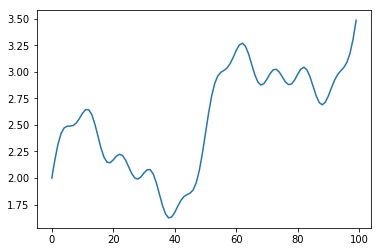

In [2]:
maxX = 100
X0 = np.arange(0, maxX)
f_true = lambda x:  0.5*np.sin(2*np.pi*x/50)+0.2*np.sin(2*np.pi*x/25)+0.1*np.sin(2*np.pi*x/10)+(0.013*x)**2+2
theta0 = f_true(X0)
plt.plot(X0, theta0);

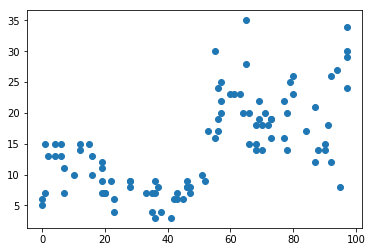

In [3]:
x = np.random.choice(X0, size=100)
lam = np.exp(f_true(x))
y_obs = np.random.poisson(lam)
plt.scatter(x, y_obs);

## Trying out different kernels
### Squared exponential

In [4]:
with pm.Model() as base_gp_model:
    ls = pm.Exponential('ls', lam=0.1)
    cov = pm.gp.cov.ExpQuad(1, ls=ls)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=x[:, None])
    lam = pm.Deterministic("lam", pm.math.exp(f))
    
    y = pm.Poisson('y', mu=lam, observed=y_obs)

In [5]:
with base_gp_model:
    base_trace = pm.sample(draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ls_log__]
  2%|▏         | 17/1000 [00:08<07:53,  2.08it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '5708' (I am process '5709')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '5708' (I am process '5710')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.

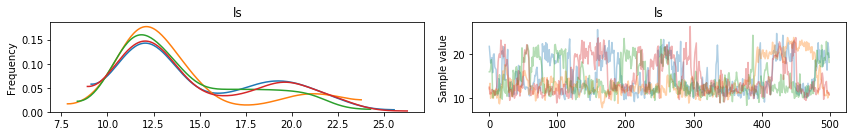

In [8]:
pm.traceplot(base_trace, varnames=['ls']);

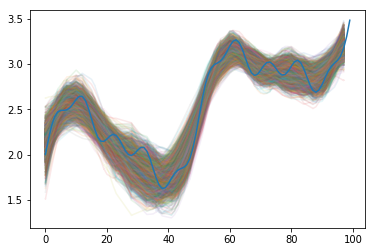

In [9]:
f_post = base_trace['f']
x_argsort = x.argsort()
_ = plt.plot(x[x_argsort], f_post.T[x_argsort, :], alpha=0.1, )
plt.plot(X0, theta0);

### Pure periodic model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, ls_log__]
  2%|▏         | 16/1000 [00:09<09:17,  1.77it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '10202' (I am process '10203')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '10202' (I am process '10204')
INFO (theano.gof.compilelock): To manually release the lock, delete /home/laoj/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-

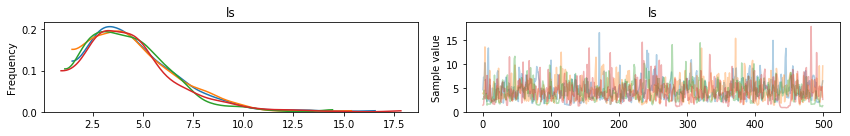

In [10]:
with pm.Model() as periodic_cov_model:
    ls = pm.Exponential('ls', lam=0.1)
    period_cov = pm.gp.cov.Periodic(1, period=50, ls=ls)
    
    gp = pm.gp.Latent(cov_func=period_cov)
    
    f = gp.prior("f", X=x[:, None])
    lam = pm.math.exp(f)
    
    y = pm.Poisson('y', mu=lam, observed=y_obs)
    
    periodic_cov_trace = pm.sample()
        
pm.traceplot(periodic_cov_trace, varnames=['ls']);

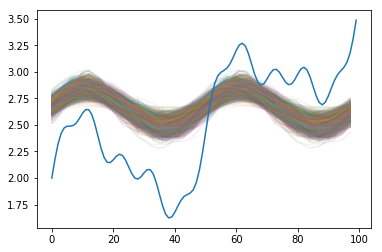

In [11]:
f_post = periodic_cov_trace['f']
x_argsort = x.argsort()
_ = plt.plot(x[x_argsort], f_post.T[x_argsort, :], alpha=0.1)
plt.plot(X0, theta0);

### Mixed periodic and squared exponential model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [f_rotated_, trend_ls_log__, period_ls_log__]
100%|██████████| 1000/1000 [14:13<00:00,  1.17it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.8787085792010402, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maxi

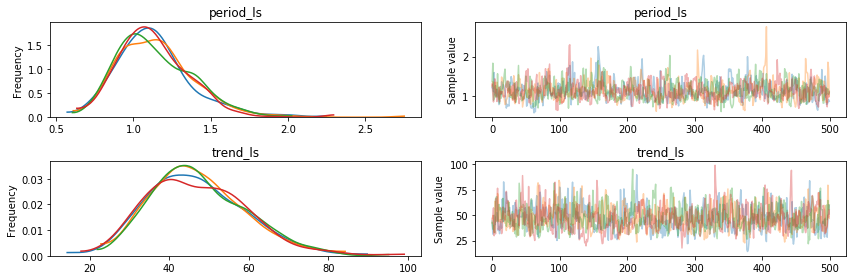

In [12]:
with pm.Model() as period_trend_model:    
    period_ls = pm.Exponential('period_ls', lam=1.0)
    period_cov = pm.gp.cov.Periodic(1, period=50, ls=period_ls)
    
    
    trend_ls = pm.Exponential('trend_ls', lam=0.1)
    trend_cov = pm.gp.cov.ExpQuad(1, ls=trend_ls)
    
    gp = pm.gp.Latent(cov_func=period_cov*trend_cov)
    
    f = gp.prior("f", X=x[:, None])
    lam = pm.math.exp(f)
    
    y = pm.Poisson('y', mu=lam, observed=y_obs)

    period_trend_trace = pm.sample()
        
pm.traceplot(period_trend_trace, varnames=['period_ls', 'trend_ls']);

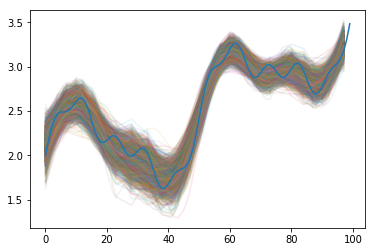

In [13]:
f_post = period_trend_trace.get_values('f')
x_argsort = x.argsort()
_ = plt.plot(x[x_argsort], f_post.T[x_argsort, :], alpha=0.1)
plt.plot(X0, theta0);

In [14]:
pm.compare([base_trace, periodic_cov_trace, period_trend_trace], 
           [base_gp_model, periodic_cov_model, period_trend_model])

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
2,549.78,9.73,0,0.98,18.26,0,1
0,560.77,11.99,10.99,0,19.11,3.2,1
1,803.49,11.2,253.71,0.02,41.75,38.77,1


100%|██████████| 500/500 [00:00<00:00, 562.93it/s]


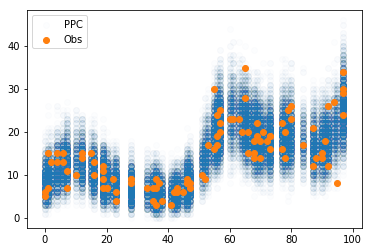

In [16]:
base_ppc_samples = pm.sample_ppc(period_trend_trace, model=period_trend_model)['y']

plt.scatter(x[:, None].repeat(500, axis=1), base_ppc_samples.T, alpha=0.01, label='PPC')
plt.scatter(x, y_obs, label='Obs')
plt.legend();

## Mixed effects dataset

Different individuals with base rates multiplied by latent function

array([0.78167601, 0.00635897, 0.42961507, 0.44864672, 4.94525675,
       0.09406729, 0.75602076, 1.62282987, 0.43466252, 1.29402006])

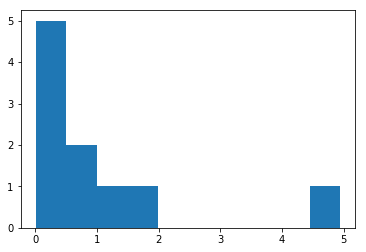

In [17]:
n_individuals = 10

individual_rates = np.random.gamma(shape=1.0, scale=1.0, size=n_individuals)
plt.hist(individual_rates);
individual_rates

In [18]:
lam2 = np.outer(individual_rates, np.exp(f_true(X0)))
y_obs2 = np.random.poisson(lam2)
y_obs2.shape

(10, 100)

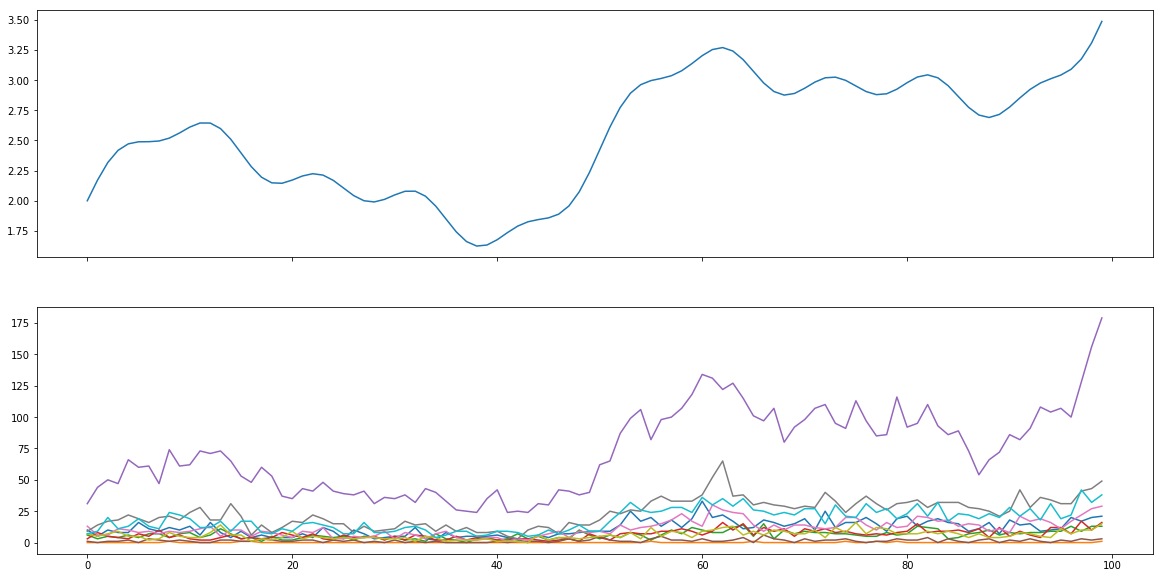

In [22]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
axs[0].plot(X0, f_true(X0))
_ = axs[1].plot(X0, y_obs2.T)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [individual_lam_log__, beta_log__, alpha_log__, f_rotated_, trend_ls_log__, period_ls_log__]
INFO:pymc3:NUTS: [individual_lam_log__, beta_log__, alpha_log__, f_rotated_, trend_ls_log__, period_ls_log__]
100%|██████████| 1000/1000 [1:16:11<00:00,  4.57s/it]
Divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:Divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree dept

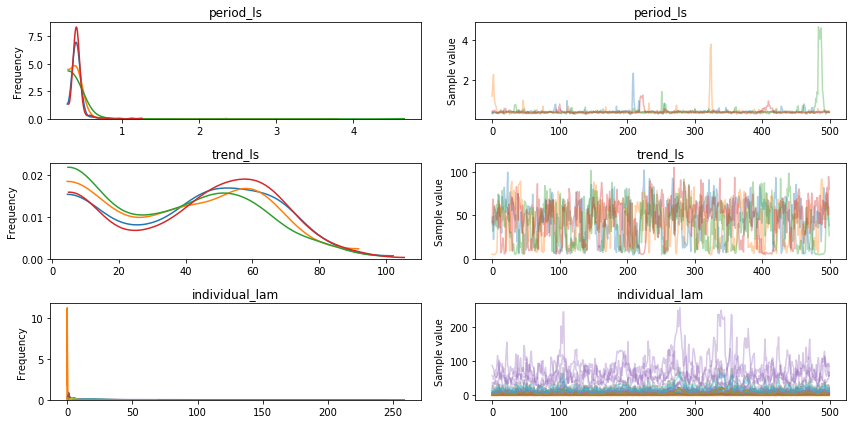

In [23]:
import theano.tensor as T

with pm.Model() as mixed_model:  
    period_ls = pm.Exponential('period_ls', lam=1.0)
    period_cov = pm.gp.cov.Periodic(1, period=50, ls=period_ls)
    trend_ls = pm.Exponential('trend_ls', lam=0.1)
    trend_cov = pm.gp.cov.ExpQuad(1, ls=trend_ls)
    
    gp = pm.gp.Latent(cov_func=period_cov*trend_cov)
    f = gp.prior("f", X=X0[:, None])
    
    base_lam = pm.Deterministic("base_lam", pm.math.exp(f))
    
    alpha = pm.Exponential('alpha', lam=0.1)
    beta = pm.Exponential('beta', lam=0.1)
    
    individual_lam = pm.Gamma('individual_lam', alpha=alpha, beta=beta, shape=(1, n_individuals))
    
    y = pm.Poisson('y', mu=T.dot(base_lam[:, None], individual_lam), observed=y_obs2.T)

    mixed_trace = pm.sample()
        
pm.traceplot(mixed_trace, varnames=['period_ls', 'trend_ls', 'individual_lam']);

#### Posterior samples of latent process

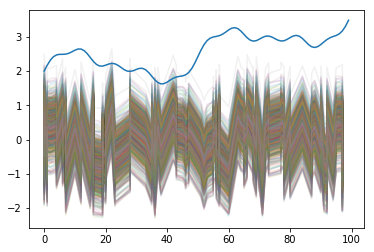

In [24]:
f_post = mixed_trace.get_values('f')
x_argsort = x.argsort()
_ = plt.plot(x[x_argsort], f_post.T[x_argsort, :], alpha=0.1)
plt.plot(X0, theta0);

#### Posterior samples of individual rates

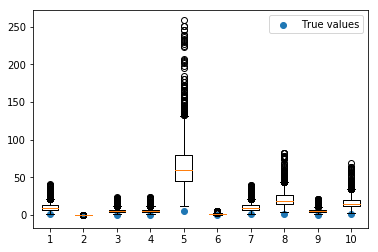

In [25]:
plt.boxplot(mixed_trace.get_values('individual_lam')[:, 0, :])
plt.scatter(list(range(1, n_individuals+1)), individual_rates, label='True values')
plt.legend();

#### Posterior predictive samples

100%|██████████| 500/500 [00:01<00:00, 318.10it/s]


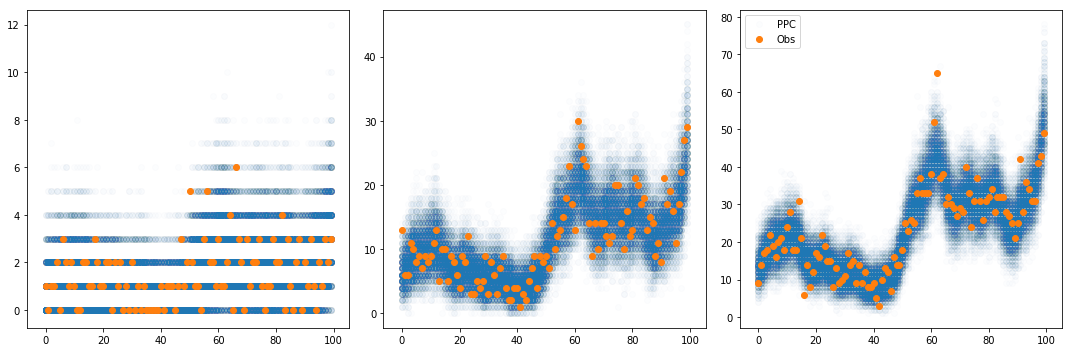

In [57]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)

mixed_ppc_samples = pm.sample_ppc(mixed_trace, model=mixed_model)['y']

for i in range(3):
    ax = axs[i]
    ax.scatter(X0[None, :].repeat(500, axis=0), mixed_ppc_samples[:, :, i+5], alpha=0.01, label='PPC')
    ax.scatter(X0, y_obs2[i+5, :], label='Obs')
ax.legend()
plt.tight_layout();

### Informative priors

In [46]:
import theano.tensor as T

with pm.Model() as model:
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    period_ls = BoundedNormal('period_ls', mu=1.0, sd=0.25)
    period_cov = pm.gp.cov.Periodic(1, period=50, ls=period_ls)
    
    trend_ls = BoundedNormal('trend_ls', mu=50, sd=20)
    trend_cov = pm.gp.cov.ExpQuad(1, ls=trend_ls)
    
    gp = pm.gp.Latent(cov_func=period_cov*trend_cov)
    f = gp.prior("f", X=X0[:, None])
    
    individual_lam = pm.Normal('individual_lam', 0, 10., shape=(1, n_individuals))
    intercept = pm.HalfNormal('c', 10.)
    base_lam = pm.math.exp(intercept + T.dot(f[:, None], individual_lam))
    y = pm.Poisson('y', mu=base_lam, observed=y_obs2.T)
    
from pymc3.step_methods.hmc import quadpotential
chains = 2
with model:
    # mixed_informative_trace = pm.sample()
    approx = pm.fit(30000)
    start = approx.sample(draws=chains)
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    mean = approx.bij.rmap(approx.mean.get_value())
    mean = model.dict_to_array(mean)
    weight = 50
    potential = quadpotential.QuadPotentialDiagAdapt(
            model.ndim, mean, cov, weight)
    step = pm.NUTS(potential=potential, model=model)

Average Loss = 2,951: 100%|██████████| 30000/30000 [02:42<00:00, 184.10it/s]    
Finished [100%]: Average Loss = 2,951
INFO:pymc3.variational.inference:Finished [100%]: Average Loss = 2,951
/home/laoj/Documents/Github/pymc3/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):


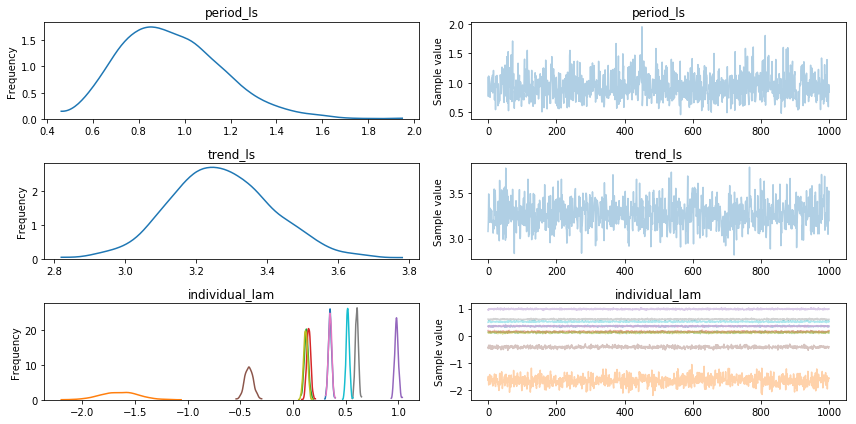

In [47]:
trace_advi = approx.sample(1000)
pm.traceplot(trace_advi, varnames=['period_ls', 'trend_ls', 'individual_lam']);

In [54]:
with model:
    mixed_informative_trace = pm.sample(step=step, start=start, chains=chains)
pm.traceplot(mixed_informative_trace, varnames=['period_ls', 'trend_ls', 'individual_lam']);

Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [c_log__, individual_lam, f_rotated_, trend_ls_lowerbound__, period_ls_lowerbound__]
INFO:pymc3:NUTS: [c_log__, individual_lam, f_rotated_, trend_ls_lowerbound__, period_ls_lowerbound__]
 10%|▉         | 99/1000 [02:51<26:00,  1.73s/it]

KeyboardInterrupt: 

In [48]:
# mixed_informative_trace = trace_advi

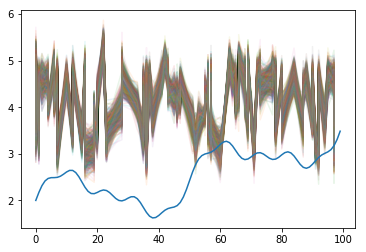

In [49]:
f_post_informative = mixed_informative_trace['f'] + mixed_informative_trace['c'][:, None]
x_argsort = x.argsort()
_ = plt.plot(x[x_argsort], f_post_informative.T[x_argsort, :], alpha=0.1)
plt.plot(X0, theta0);

In [52]:
informative_ppc_samples.shape

(1000, 100, 10)

100%|██████████| 500/500 [00:01<00:00, 359.49it/s]


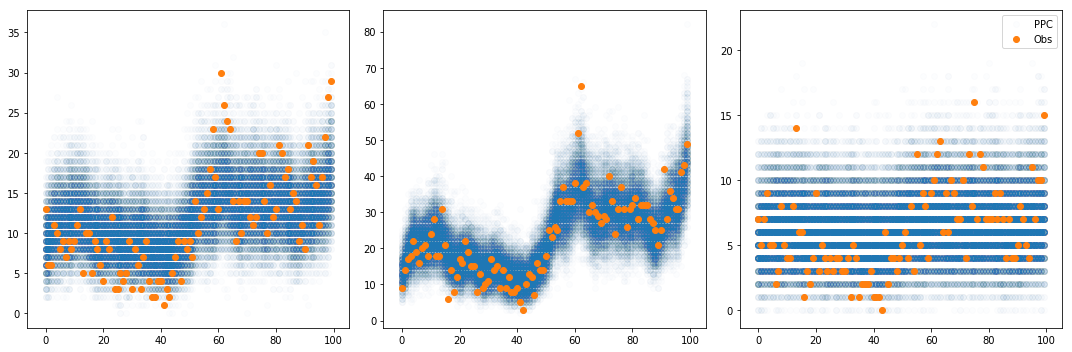

In [56]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5), sharex=True)

informative_ppc_samples = pm.sample_ppc(mixed_informative_trace, model=model, samples=500)['y']
sss = 6
for i in range(3):
    ax = axs[i]
    ax.scatter(X0[None, :].repeat(500, axis=0), informative_ppc_samples[:, :, i+sss], alpha=0.01, label='PPC')
    ax.scatter(X0, y_obs2[i+sss, :], label='Obs')
ax.legend()
plt.tight_layout();